# Linear stability analysis of the system
This notebook studies the linear stability of the system as the initial conditions vary. The condition can be modified one variable at a time, after which the system is evolved for a time t_max set in the configuration file. It is recommended to use t_max = 500 weeks, in order to be reasonably close to the stationary state. At this point, the final values of the state variables are substituted, and the eigenvalues of the Jacobian matrix are calculated. A plot of the real and imaginary parts of these eigenvalues, as the selected initial condition changes, is displayed. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import configparser
import pandas as pd
import os
from functools import partial 
from scipy.integrate import solve_ivp
from scipy.linalg import eig

### Function to retrieve information from the configuration file

In [2]:
def extract_values(section_name, config):
    values = []
    if section_name in config:
        for key, value in config[section_name].items():
            values.append(float(value))
    else:
        print(f'Section "{section_name}" is not in the configuration file')
    return values

### One-step update in the system's evolution

In [3]:
def one_step(t, dt, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par

    for i in range(len(H)):

        ev_H(i, dt, d_H, k1, H_i, H, M, D, H_new)
        ev_C(i, dt, d_C, k2, C_i, C, H, D, C_new)
        ev_M(i, dt, d_M, k3, M_i, M, D, M_new)
        ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new)
        ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new)
        R_new[i] = 100 - N_new[i] - D_new[i]
        

### Original system of differential equations
The following cell is only for the Runge-Kutta implementation.

In [4]:
#System
def DMD_model(t, state_variables, initial_conditions, parameters):

    H, C, M, N, D, R = state_variables
    H_i, C_i, M_i, N_i, D_i, R_i = initial_conditions
    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = parameters
    
    dHdt=eq_H(H, M, D, H_i, k1, d_H)
    dCdt=eq_C(H, C, D, C_i, k2, d_C)
    dMdt=eq_M(M, D, M_i, k3, d_M)
    dNdt=eq_N(t, C, N, R, R_i, k4, k5, sigma, m, h)
    dDdt=eq_D(t, C, M, N, D, D_i, k5, k6, d_D, sigma, m, h)
    dRdt=eq_R(M, D, R, R_i, k4, k6, d_D)

    return [dHdt, dCdt, dMdt, dNdt, dDdt, dRdt]

#Equations
def eq_H(H, M, D, H_i, k1, d_H):
    b_H = d_H * H_i 
    return b_H + k1 * M * D - d_H * H

def eq_C(H, C, D, C_i, k2, d_C):
    b_C = d_C * C_i
    return b_C + k2 * H * D - d_C * C

def eq_M(M, D, M_i, k3, d_M):
    b_M = d_M * M_i
    return b_M + k3 * M * D - d_M * M

def eq_N(t, C, N, R, R_i, k4, k5, sigma, m, h):
    return k4 * R - k5 * C * N - damage(t, sigma, m, h) * N

def eq_D(t, C, M, N, D, D_i, k5, k6, d_D, sigma, m, h):
    return k5 * C * N + damage(t, sigma, m, h) * N - k6 * D * M - d_D * D

def eq_R( M, D, R, R_i, k4, k6, d_D):
    return k6 * D * M + d_D * D - k4 * R  

### Damage function

In [5]:
def damage(t, sigma, m, h):

    if t==0 or t <=1e-14:
        return 0.
    else:
       return h / (t * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(t) - m)**2 / (2. * sigma**2))

### Evolution of the immune cells
Since we are studying the homogeneous scenario, diffusion has been excluded.

In [6]:
def ev_H(i, dt, d_H, k1, H_i, H, M, D, H_new):
    H_new[i] = H[i] + dt * (k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))

def ev_C(i, dt, d_C, k2, C_i, C, H, D, C_new):
    C_new[i] = C[i] + dt * (k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
   
def ev_M(i, dt, d_M, k3, M_i, M, D, M_new):
    M_new[i] = M[i] + dt * (k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
        

### Evolution of the composition of muscle tissue

In [7]:
def ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
    
def ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))

def ev_R(i, dt, d_D, k4, k6, M, D, R, R_new):
    R_new[i] = R[i] + dt * (D[i] * (k6 * M[i] + d_D) - k4 * R[i])

### Save the output to a .csv file

In [8]:
def save_to_csv(output_list, column_name, directory, file_name):
    os.makedirs(directory, exist_ok=True)
    
    file_path = os.path.join(directory, file_name)
    
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        df = pd.DataFrame()

    df[column_name] = output_list
    
    df.to_csv(file_path, index=False)

### Define which kind of state variable one is working with (tissue or immune cells)
This function recognises whether or not the given variable is a type of fibre in muscle tissue.

In [9]:
def is_muscle_tissue(var):
    if var in ['N', 'D', 'R']:
        return True
    else:
        return False

### Jacobian matrix

In [10]:
def jacobian(H, C, M, N, D, par, H_i, C_i, M_i):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par

#Initialize the Jacobian matrix: 5x5 for 5 independent variables H, C, M, N, D (R is a linear combination of N and D)
    J = np.zeros((5, 5))
    
#Partial derivatives of eq_H = d_H * H_i + k1 * D * M - d_H * H
    J[0, 0] = - d_H
    J[0, 2] = k1 * D
    J[0, 4] = k1 * M
    
#Partial derivatives of eq_C = d_C * C_i + k2 * D * H - d_C * C
    J[1, 0] = k2 * D
    J[1, 1] = - d_C
    J[1, 4] = k2 * H
    
#Partial derivatives of eq_M = d_M * M_i + k3 * D * M - d_M * M
    J[2, 2] = k3 * D - d_M
    J[2, 4] = k3 * M
    
#Partial derivatives of eq_N = k4 * (100 - N - D) - k5 * C * N 
    J[3, 1] = - k5 * N
    J[3, 3] = - k5 * C - k4
    J[3, 4] = - k4
    
#Partial derivatives of eq_D = k5 * C * N - k6 * D * M - d_D * D
    J[4, 1] = k5 * N
    J[4, 2] = - k6 * D
    J[4, 3] = k5 * C
    J[4, 4] = - k6 * M - d_D

    return J    

### Simulation
The variable var defines which of the six state variables will be modified in its initial value, relative to the data provided by the reference paper. Various possible values are then extracted, and the system is evolved using Euler, Runge-Kutta, or both, starting from the new initial conditions. For each condition, the final configuration reached by the system is stored.

In [30]:
RUNGE_KUTTA = True
EULER = True

#Extract the needed parameters from the configuration file
config = configparser.ConfigParser()
config.read('config_linear_stability.ini')

#Parameters and initial conditions
par = extract_values('parameters', config)
i_c = np.array(extract_values('initial_conditions', config))
i_c_stored = i_c.copy() #keeps track of the initial condition in config.ini
sim = extract_values('simulation_par', config)
dt, t_min, t_max, N_cells = sim
N_cells = int(N_cells)
time = t_min

if RUNGE_KUTTA:
    tolerance_RK = extract_values('runge_kutta', config)
    relative_tol, absolute_tol = tolerance_RK
    
    t_span = (0, t_max)
    t_eval = np.linspace(0, t_max, 1000)

'''The broader values from the paper are as follows, but they can be adjusted to focus on a region of particular interest'''
bounds = [(0, 4500), (0, 450), (0, 100000), (0, 100), (0, 100), (0, 100)]
num_samples = [101, 101, 101, 101, 101, 101]
var = 'R'
is_percentage = is_muscle_tissue(var)

n_vars = 6
labels = ['CD4_T_cells', 'CD8_T_cells', 'macrophages', 'normal_fibres', 'damaged_fibres', 'regenerating_fibres']
var_map = {
    'H': 0,
    'C': 1,
    'M': 2,
    'N': 3, 
    'D': 4, 
    'R': 5
}

time_steps = np.linspace(t_min, t_max, int((t_max - t_min) / dt) + 1)
#Sample the chosen state variable in the predefined bounds
sample = np.linspace(*bounds[var_map[var]], num_samples[var_map[var]])

# {H, C, M, N, D, R} - var
remaining_vars = []    
for choice in var_map.keys():
    if choice != var:
        remaining_vars.append(choice)

if EULER:
    configuration_t_max = []
if RUNGE_KUTTA:
    configuration_t_max_RK = []

for i in range(num_samples[var_map[var]]):
#At each iteration, the system is reset to its original state and the initial condition is then updated
    i_c = i_c_stored.copy()
    i_c[var_map[var]] = sample[i]

    '''Mass conservation must be maintained in the initial conditions, \
so if N_i, D_i or R_i are changed, the others must be adjusted accordingly'''
    if is_percentage:
        second, third = remaining_vars[3:5] #the last two variables are the ones referring to muscle tissue
        if 100 - i_c[var_map[var]] - i_c[var_map[second]] >= 0:
            i_c[var_map[third]] = 100. - i_c[var_map[var]] - i_c[var_map[second]]
        elif 100 - i_c[var_map[var]] - i_c[var_map[third]] >= 0:
            i_c[var_map[second]] = 100. - i_c[var_map[var]] - i_c[var_map[third]]
        else:
            i_c[var_map[second]] = 100. - i_c[var_map[var]]
            i_c[var_map[third]] = 0.

    if EULER:
        H, C, M, N, D, R = [[i_c[k]] * N_cells for k in range(n_vars)]
        H_i, C_i, M_i, N_i, D_i, R_i = [[i_c[k]] * N_cells for k in range(n_vars)]
        H_new, C_new, M_new, N_new, D_new, R_new = [[i_c[k]] * N_cells for k in range(n_vars)]
    
        time = t_min
        
        for j in time_steps:
            
            one_step(time, dt, H, C, M, N, D, R, 
                     H_new, C_new, M_new, N_new, D_new, R_new, 
                     H_i, C_i, M_i, par)
            
            H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()
            time = round(time + dt, 2)
    
        configuration_t_max.append([float(H_new[1]), float(C_new[1]), float(M_new[1]), float(N_new[1]), float(D_new[1]), float(R_new[1])])
    
    if RUNGE_KUTTA:
        DMD_model_ic = partial(DMD_model, initial_conditions = i_c, parameters=par)

        solution = solve_ivp(DMD_model_ic,
                               t_span,
                               i_c,
                               method='RK45',
                               t_eval=t_eval,
                               rtol=relative_tol,
                               atol=absolute_tol
                              )
        
        values = solution.y
        configuration_t_max_RK.append([values[0][-1], values[1][-1], values[2][-1], values[3][-1], values[4][-1], values[5][-1]])

#Print this to keep track of the evolution:
    print(f'H_i = {i_c[0]}, C_i = {i_c[1]}, M_i = {i_c[2]}, N_i = {i_c[3]}, D_i = {i_c[4]}, R_i = {i_c[5]}')

directory = f'sample_{var}i/time_{t_max}_dt_{dt}_range_{bounds[var_map[var]][0]}_{bounds[var_map[var]][1]}/'

H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 99.0, D_i = 0.0, R_i = 1.0
H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 98.0, D_i = 0.0, R_i = 2.0
H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 97.0, D_i = 0.0, R_i = 3.0
H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 96.0, D_i = 0.0, R_i = 4.0
H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 95.0, D_i = 0.0, R_i = 5.0
H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 94.0, D_i = 0.0, R_i = 6.0
H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 93.0, D_i = 0.0, R_i = 7.0
H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 92.0, D_i = 0.0, R_i = 8.0
H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 91.0, D_i = 0.0, R_i = 9.0
H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 90.0, D_i = 0.0, R_i = 10.0
H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 89.0, D_i = 0.0, R_i = 11.0
H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 88.0, D_i = 0.0, R_i = 12.0
H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 87.0, D_i = 0.0, R_i = 13.0
H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 86

The following cell computes the eigenvalues of the Jacobian matrix at t_max. If SAVE_csv = True, it also saves the real and imaginary parts, together with the corresponding configuration, in a .csv file.

In [31]:
SAVE_csv = True

real_eigenvalues = []
real_eigenvalues_RK = []
imaginary_eigenvalues = []
imaginary_eigenvalues_RK = []
working_configurations = []
working_configurations_RK = []
working_sample = []
working_sample_RK = []

for i in range(num_samples[var_map[var]]):
    if EULER:

        '''The only values stored and plotted will be those for which the code has not apparently encountered numerical issues.
The final configurations for which the evolution resulted in an error are thus excluded a priori from the eigenvalue calculation.'''
        if not np.any(np.isnan(configuration_t_max[i])):
            H, C, M, N, D, R = configuration_t_max[i]

            j_matrix = jacobian(H, C, M, N, D, par, H_i, C_i, M_i)
            J = j_matrix 
            try:
                eigenvalues = eig(J)[0]
                real_part = eigenvalues.real
                imaginary_part = eigenvalues.imag
                real_eigenvalues.append(real_part.tolist())
                imaginary_eigenvalues.append(imaginary_part.tolist())
                
                '''The only configurations stored are those for which the eigenvalue calculation did not result in an error.'''
                working_configurations.append(configuration_t_max[i])
                working_sample.append(sample[i])
                
                #if all(np.real(eigenvalues) < 0):
                 #   print(f'Eigenvalues of the Jacobian (Euler): {eigenvalues} --> fixed point stable.')
                #else:
                 #   print(f'Eigenvalues of the Jacobian (Euler): {eigenvalues} --> fixed point unstable.')
            except ValueError as e:
                print(f"Matrix {i}: Error - {e}. Skipping...")

    if RUNGE_KUTTA:

        if not np.any(np.isnan(configuration_t_max_RK[i])):
            H, C, M, N, D, R = configuration_t_max_RK[i]
            
        j_matrix = jacobian(H, C, M, N, D, par, H_i, C_i, M_i)
        J = j_matrix 
        try:
            eigenvalues = eig(J)[0]
            real_part = eigenvalues.real
            imaginary_part = eigenvalues.imag
            real_eigenvalues_RK.append(real_part.tolist()) 
            imaginary_eigenvalues_RK.append(imaginary_part.tolist())
            
            working_configurations_RK.append(configuration_t_max_RK[i])
            working_sample_RK.append(sample[i])
            
            #if all(np.real(eigenvalues) < 0):
             #   print(f'Eigenvalues of the Jacobian (Runge-Kutta): {eigenvalues} --> fixed point stable.')
            #else:
             #   print(f'Eigenvalues of the Jacobian (Runge-Kutta): {eigenvalues} --> fixed point unstable.')
        except ValueError as e:
            print(f"Matrix {i}: Error - {e}. Skipping...")

if EULER and SAVE_csv:
    save_to_csv([row[0] for row in working_configurations], labels[0], directory, f'eigenvalues_{t_max}_weeks_euler.csv')
    save_to_csv([row[1] for row in working_configurations], labels[1], directory, f'eigenvalues_{t_max}_weeks_euler.csv')
    save_to_csv([row[2] for row in working_configurations], labels[2], directory, f'eigenvalues_{t_max}_weeks_euler.csv')
    save_to_csv([row[3] for row in working_configurations], labels[3], directory, f'eigenvalues_{t_max}_weeks_euler.csv')
    save_to_csv([row[4] for row in working_configurations], labels[4], directory, f'eigenvalues_{t_max}_weeks_euler.csv')
    save_to_csv([row[5] for row in working_configurations], labels[5], directory, f'eigenvalues_{t_max}_weeks_euler.csv')
    save_to_csv([row[0] for row in real_eigenvalues], 'real_part_eig_1', directory, f'eigenvalues_{t_max}_weeks_euler.csv')
    save_to_csv([row[0] for row in imaginary_eigenvalues], 'imaginary_part_eig_1', directory, f'eigenvalues_{t_max}_weeks_euler.csv')
    save_to_csv([row[1] for row in real_eigenvalues], 'real_part_eig_2', directory, f'eigenvalues_{t_max}_weeks_euler.csv')
    save_to_csv([row[1] for row in imaginary_eigenvalues], 'imaginary_part_eig_2', directory, f'eigenvalues_{t_max}_weeks_euler.csv')
    save_to_csv([row[2] for row in real_eigenvalues], 'real_part_eig_3', directory, f'eigenvalues_{t_max}_weeks_euler.csv')
    save_to_csv([row[2] for row in imaginary_eigenvalues], 'imaginary_part_eig_3', directory, f'eigenvalues_{t_max}_weeks_euler.csv')
    save_to_csv([row[3] for row in real_eigenvalues], 'real_part_eig_4', directory, f'eigenvalues_{t_max}_weeks_euler.csv')
    save_to_csv([row[3] for row in imaginary_eigenvalues], 'imaginary_part_eig_4', directory, f'eigenvalues_{t_max}_weeks_euler.csv')
    save_to_csv([row[4] for row in real_eigenvalues], 'real_part_eig_5', directory, f'eigenvalues_{t_max}_weeks_euler.csv')
    save_to_csv([row[4] for row in imaginary_eigenvalues], 'imaginary_part_eig_5', directory, f'eigenvalues_{t_max}_weeks_euler.csv')

if RUNGE_KUTTA and SAVE_csv:
    save_to_csv([row[0] for row in working_configurations_RK], labels[0], directory, f'eigenvalues_{t_max}_weeks_RK.csv')
    save_to_csv([row[1] for row in working_configurations_RK], labels[1], directory, f'eigenvalues_{t_max}_weeks_RK.csv')
    save_to_csv([row[2] for row in working_configurations_RK], labels[2], directory, f'eigenvalues_{t_max}_weeks_RK.csv')
    save_to_csv([row[3] for row in working_configurations_RK], labels[3], directory, f'eigenvalues_{t_max}_weeks_RK.csv')
    save_to_csv([row[4] for row in working_configurations_RK], labels[4], directory, f'eigenvalues_{t_max}_weeks_RK.csv')
    save_to_csv([row[5] for row in working_configurations_RK], labels[5], directory, f'eigenvalues_{t_max}_weeks_RK.csv')
    save_to_csv([row[0] for row in real_eigenvalues_RK], 'real_part_eig_1', directory, f'eigenvalues_{t_max}_weeks_RK.csv')
    save_to_csv([row[0] for row in imaginary_eigenvalues_RK], 'imaginary_part_eig_1', directory, f'eigenvalues_{t_max}_weeks_RK.csv')
    save_to_csv([row[1] for row in real_eigenvalues_RK], 'real_part_eig_2', directory, f'eigenvalues_{t_max}_weeks_RK.csv')
    save_to_csv([row[1] for row in imaginary_eigenvalues_RK], 'imaginary_part_eig_2', directory, f'eigenvalues_{t_max}_weeks_RK.csv')
    save_to_csv([row[2] for row in real_eigenvalues_RK], 'real_part_eig_3', directory, f'eigenvalues_{t_max}_weeks_RK.csv')
    save_to_csv([row[2] for row in imaginary_eigenvalues_RK], 'imaginary_part_eig_3', directory, f'eigenvalues_{t_max}_weeks_RK.csv')
    save_to_csv([row[3] for row in real_eigenvalues_RK], 'real_part_eig_4', directory, f'eigenvalues_{t_max}_weeks_RK.csv')
    save_to_csv([row[3] for row in imaginary_eigenvalues_RK], 'imaginary_part_eig_4', directory, f'eigenvalues_{t_max}_weeks_RK.csv')
    save_to_csv([row[4] for row in real_eigenvalues_RK], 'real_part_eig_5', directory, f'eigenvalues_{t_max}_weeks_RK.csv')
    save_to_csv([row[4] for row in imaginary_eigenvalues_RK], 'imaginary_part_eig_5', directory, f'eigenvalues_{t_max}_weeks_RK.csv')

The real and imaginary parts of the eigenvalues can be visualised as a function of the initial value assigned to var.

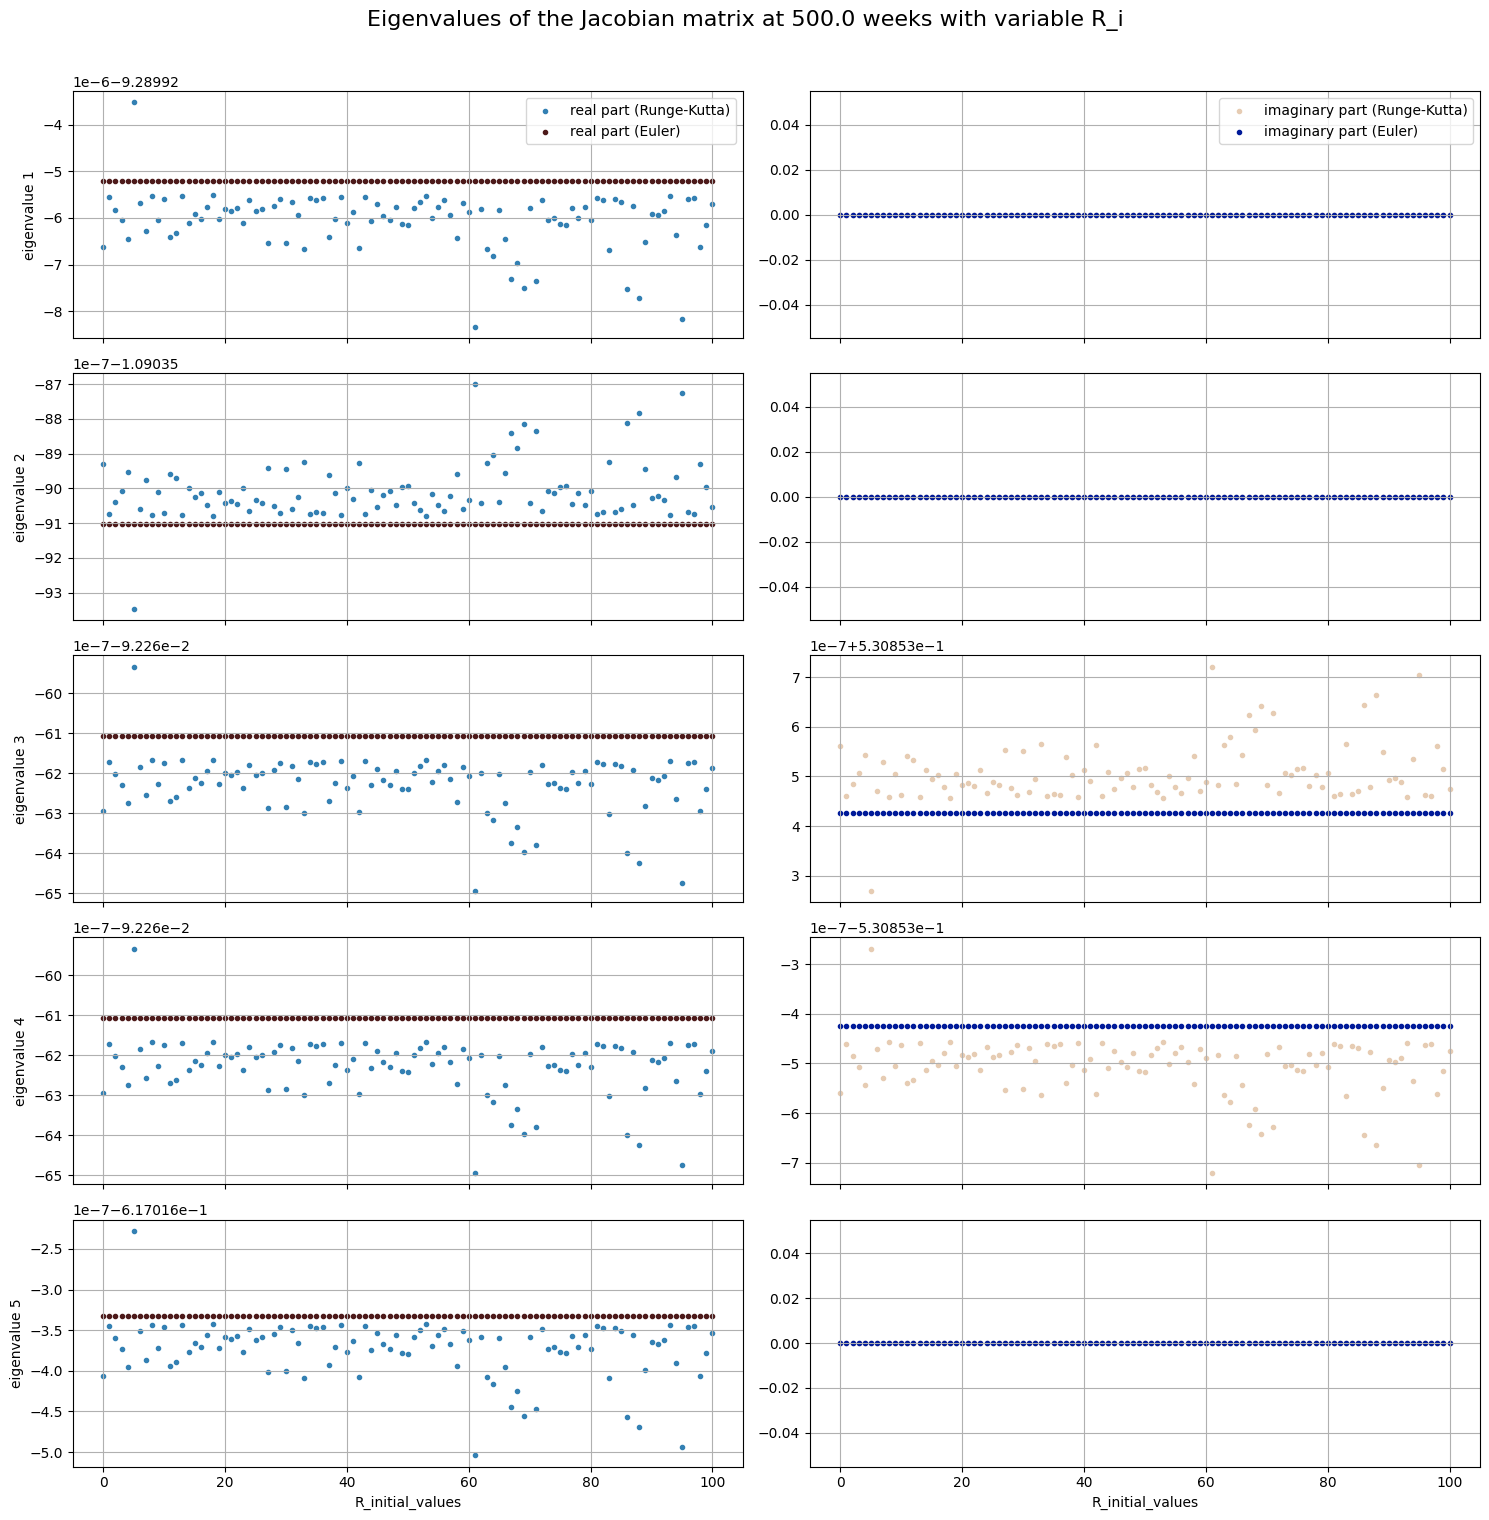

In [32]:
fig, axes = plt.subplots(5, 2, figsize=(15, 15), sharex=True)

for i in range(5):
    if RUNGE_KUTTA:
        axes[i, 0].scatter(working_sample_RK, [row[i] for row in real_eigenvalues_RK], label=f'real part (Runge-Kutta)', color=(0.2, 0.5, 0.7), marker='.')
        axes[i, 1].scatter(working_sample_RK, [row[i] for row in imaginary_eigenvalues_RK], label=f'imaginary part (Runge-Kutta)', color=(0.9, 0.8, 0.7), marker='.')
        axes[i, 0].set_ylabel(f'eigenvalue {i+1}')
        axes[i, 0].grid(True)
        axes[i, 1].grid(True)
    if EULER:
        axes[i, 0].scatter(working_sample, [row[i] for row in real_eigenvalues], label=f'real part (Euler)', color=(0.3, 0.1, 0.1), marker='.')
        axes[i, 1].scatter(working_sample, [row[i] for row in imaginary_eigenvalues], label=f'imaginary part (Euler)', color=(0.0, 0.1, 0.6), marker='.')
        axes[i, 0].set_ylabel(f'eigenvalue {i+1}')
        axes[i, 0].grid(True)
        axes[i, 1].grid(True)    
        
axes[4, 0].set_xlabel(f'{var}_initial_values')
axes[4, 1].set_xlabel(f'{var}_initial_values')
axes[0, 0].legend()
axes[0, 1].legend()

fig.suptitle(f'Eigenvalues of the Jacobian matrix at {t_max} weeks with variable {var}_i', fontsize=16, y=1.01)

if EULER and not RUNGE_KUTTA:
    filename = (
        f'eigenvalues_J'
        f'_{num_samples[var_map[var]]}_samples'
        f'_euler.png'
    )

    filepath = directory + filename

elif EULER and RUNGE_KUTTA:
    filename = (
        f'eigenvalues_J'
        f'_{num_samples[var_map[var]]}_samples'
        f'_euler&RK'
        f'_rtol_{relative_tol}'
        f'_atol_{absolute_tol}.png'
    )

    filepath = directory + filename
    
elif not EULER and RUNGE_KUTTA:
    filename = (
        f'eigenvalues_J'
        f'_{num_samples[var_map[var]]}_samples'
        f'_RK'
        f'_rtol_{relative_tol}'
        f'_atol_{absolute_tol}.png'
    )

    filepath = directory + filename

plt.savefig(filepath)

plt.tight_layout()
plt.show()